<a href="https://colab.research.google.com/github/serivan/mldmlab/blob/master/MLP_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Network From Scratch with NumPy and MNIST
Learn the fundamentals of how you can build neural networks without the help of the deep learning frameworks, and instead by using NumPy.

Creating complex neural networks with different architectures in Python should be a standard practice for any Machine Learning Engineer and Data Scientist. But a genuine understanding of how a neural network works is equally as valuable. This is what we aim to expand on in this article, the very fundamentals on how we can build neural networks, without the help of the frameworks that make it easy for us.



# Neural Networks From Scratch

The idea is that we show the very explicit implementation in NumPy, where we have to do much of the work, then afterwards, we switch to the most popular Python packages for building neural networks, to show just how easier it makes our lives.

- NumPy
- TensorFlow

Made for and explained at [mlfromscratch.com/neural-networks-tutorial/](mlfromscratch.com/neural-networks-tutorial/).

We will focus on the following 4-layer neural network, with fully connected layers in this notebook. Ideally, you can develop further on and improve the NumPy approach, while modifying the layers in PyTorch and TensorFlow to use convolutions and filters.

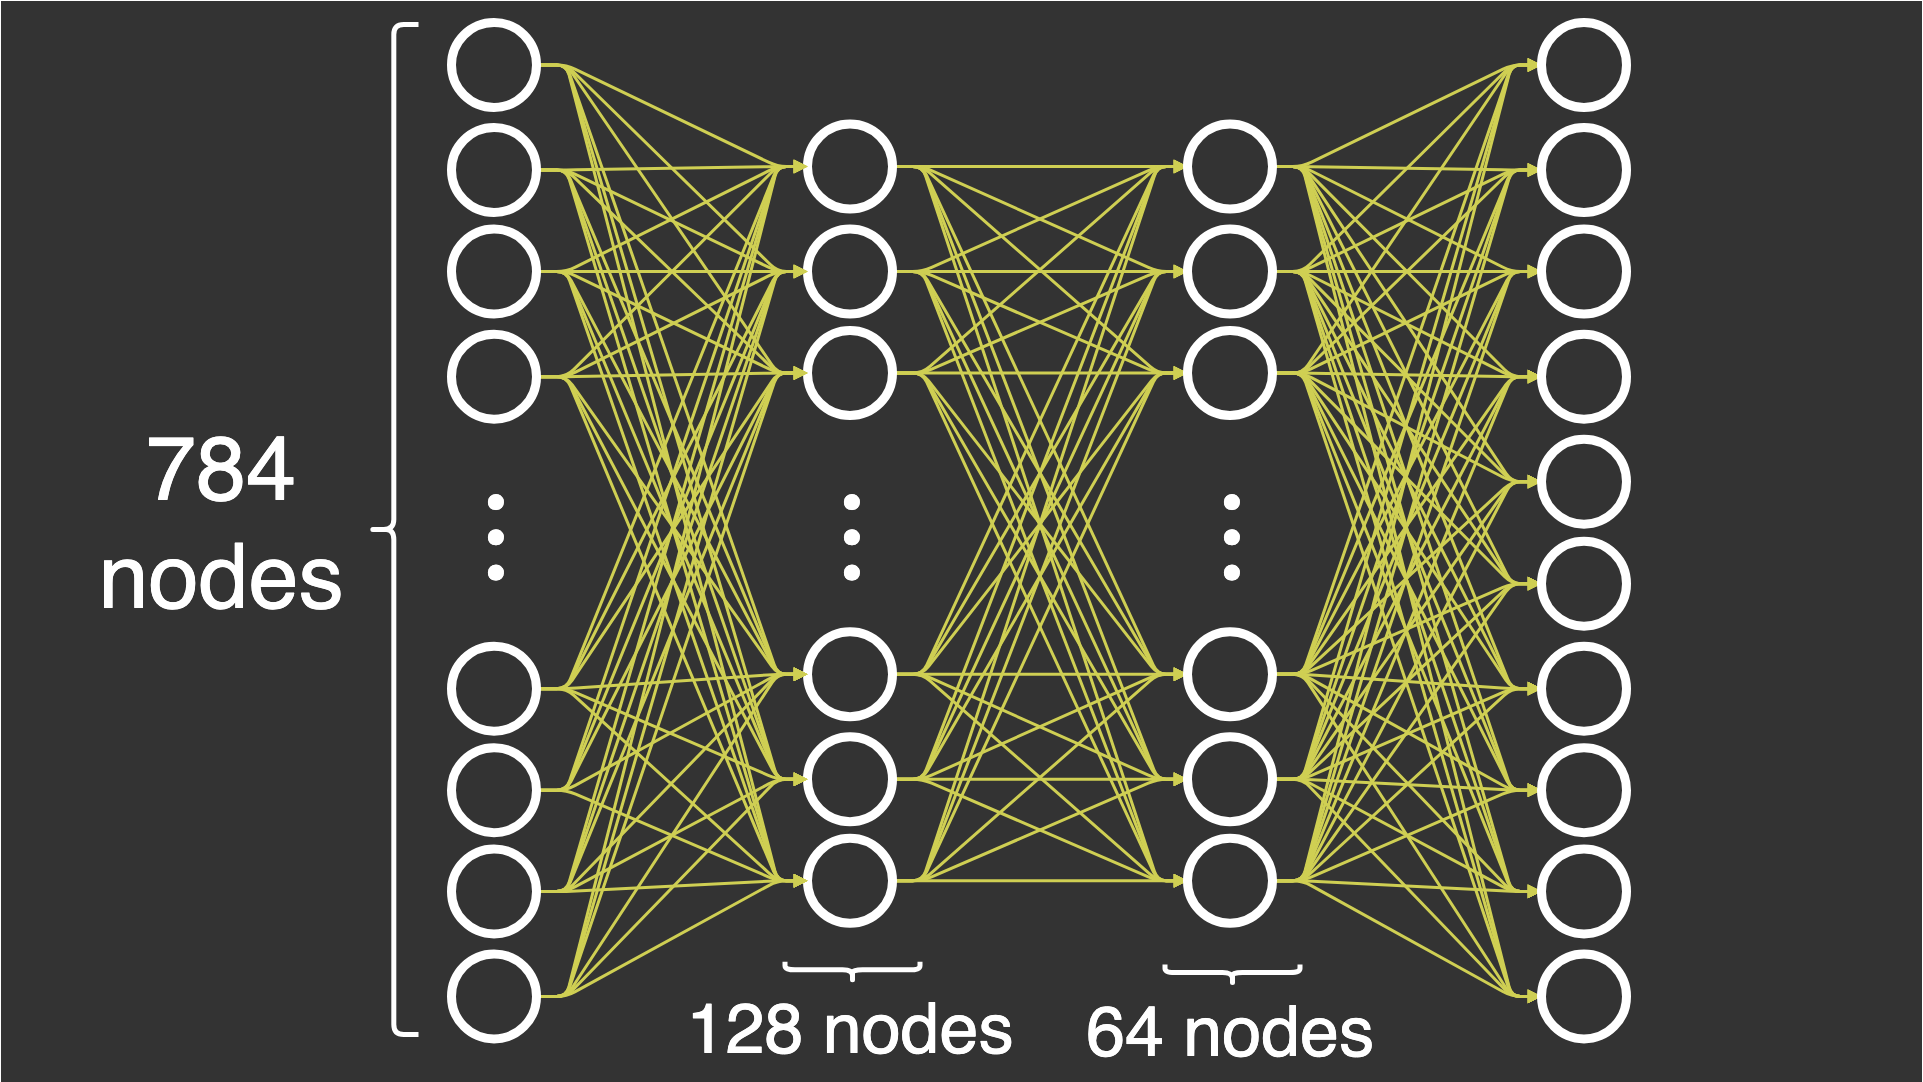

# Neural Networks From Scratch

The idea is that we show the very explicit implementation in NumPy, where we have to do much of the work, then afterwards, we switch to the most popular Python packages for building neural networks, to show just how easier it makes our lives.

- NumPy
- TensorFlow
- PyTorch

Made for and explained at [mlfromscratch.com/neural-networks-tutorial/](mlfromscratch.com/neural-networks-tutorial/).

We will focus on the following 4-layer neural network, with fully connected layers in this notebook. Ideally, you can develop further on and improve the NumPy approach, while modifying the layers in PyTorch and TensorFlow to use convolutions and filters.

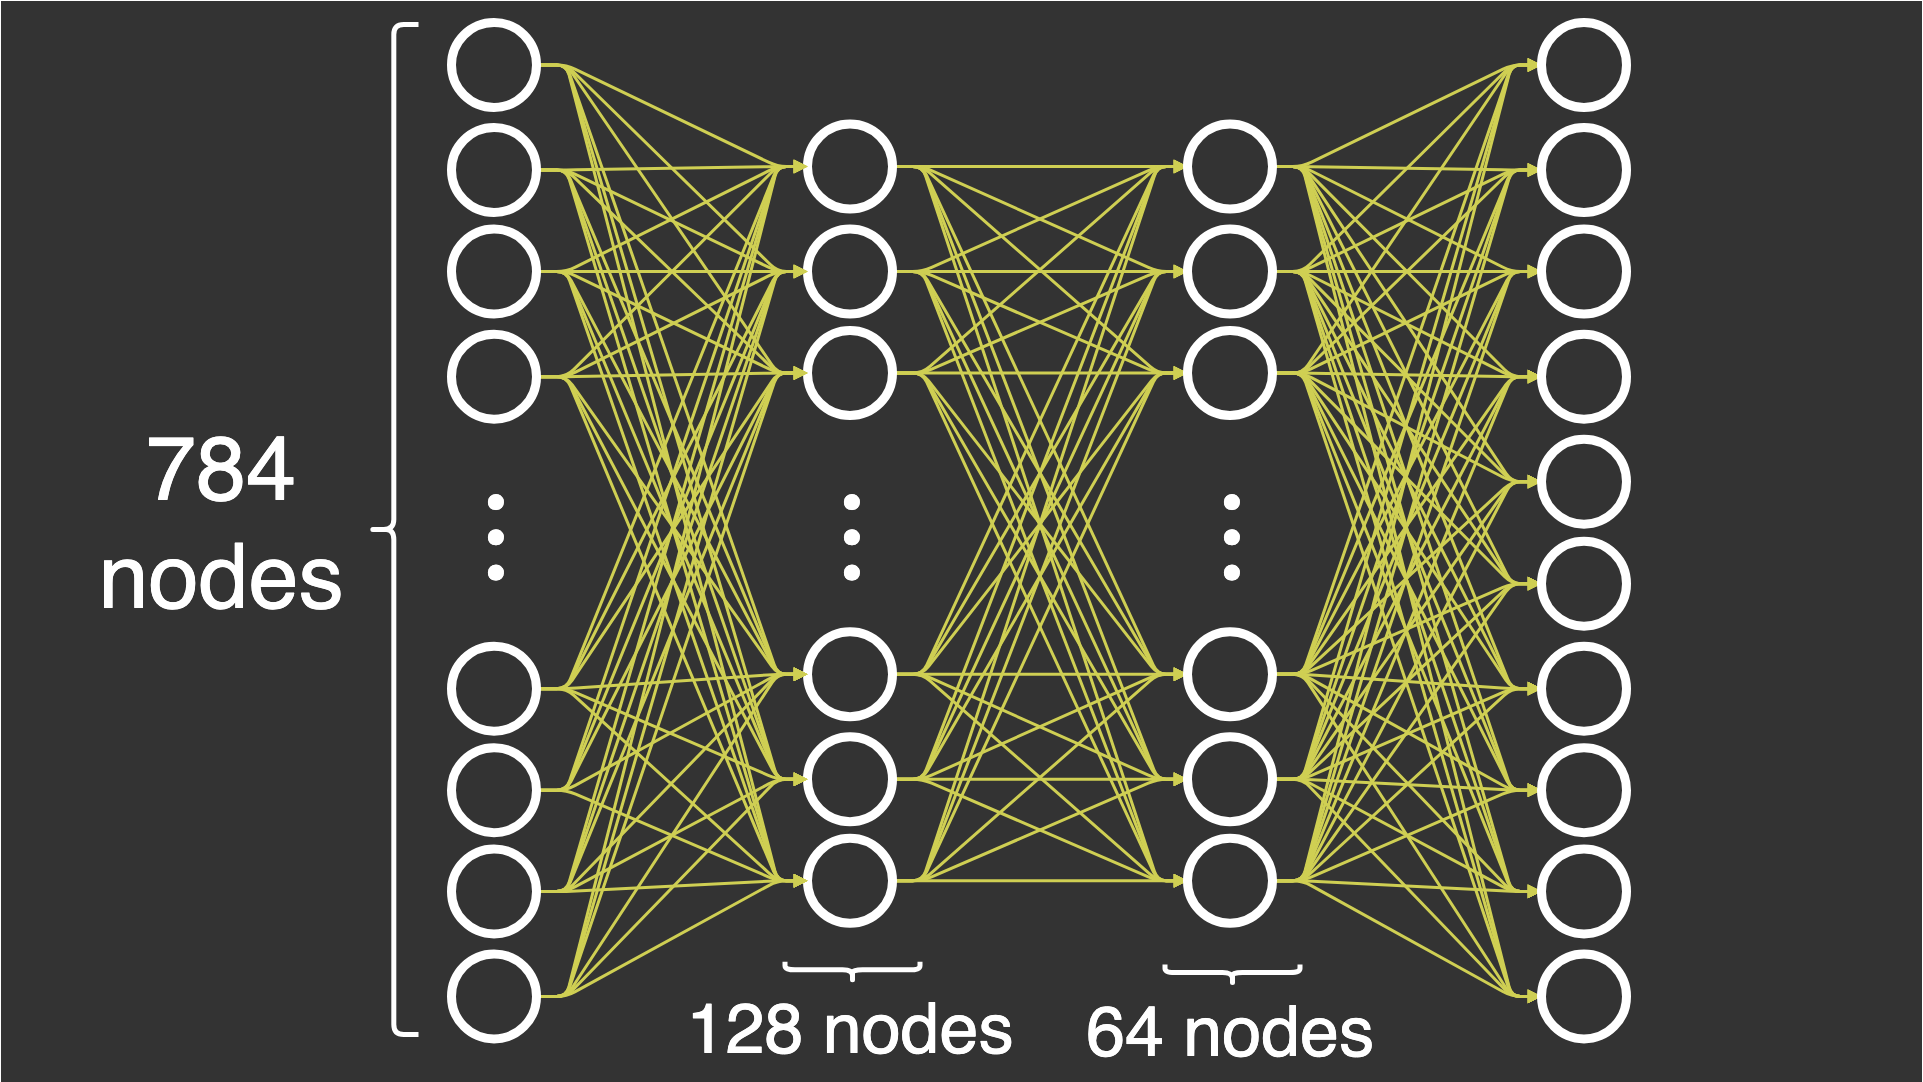

# NumPy

This is the hardest one to implement, since we will have to lay out most of the groundwork ourselves, for this approach to work. Comparatively, TensorFlow and PyTorch is much easier, which we will see later on.

In [82]:
from sklearn.datasets import fetch_openml
from keras.utils.np_utils import to_categorical
import numpy as np
from sklearn.model_selection import train_test_split
import time
import random

random.seed(10)


class DeepNeuralNetwork():
    def __init__(self, sizes, epochs=10, l_rate=0.001):
        self.sizes = sizes
        self.epochs = epochs
        self.l_rate = l_rate

        # we save all parameters in the neural network in this dictionary
        self.params = self.initialization()

    def sigmoid(self, x, derivative=False):      
        if derivative:
            return (np.exp(-x))/((np.exp(-x)+1)**2)
            sigma=1/(1 + np.exp(-x))
            return sigma* (1-sigma)
        return 1/(1 + np.exp(-x))

    def softmax(self, x, derivative=False):
        # Numerically stable with large exponentials
        exps = np.exp(x - x.max())
        if derivative:
            return exps / np.sum(exps, axis=0) * (1 - exps / np.sum(exps, axis=0))
        return exps / np.sum(exps, axis=0)


    def activation(self, x, derivative=False):
        return self.sigmoid(x, derivative)

    def initialization(self):
        # number of nodes in each layer
        input_layer=self.sizes[0]
        hidden_1=self.sizes[1]
        hidden_2=self.sizes[2]
        output_layer=self.sizes[3]

        params = {
            'W1':np.random.randn(hidden_1, input_layer) * np.sqrt(1. / hidden_1),
            'W2':np.random.randn(hidden_2, hidden_1) * np.sqrt(1. / hidden_2),
            'W3':np.random.randn(output_layer, hidden_2) * np.sqrt(1. / output_layer)
        }

        return params

    def forward_pass(self, x_train):
        params = self.params

        # input layer activations becomes sample
        params['A0'] = x_train

        # input layer to hidden layer 1
        params['Z1'] = np.dot(params["W1"], params['A0'])
        params['A1'] = self.activation(params['Z1'])

        # hidden layer 1 to hidden layer 2
        params['Z2'] = np.dot(params["W2"], params['A1'])
        params['A2'] = self.activation(params['Z2'])

        # hidden layer 2 to output layer
        params['Z3'] = np.dot(params["W3"], params['A2'])
        params['A3'] = self.softmax(params['Z3'])

        return params['A3']

    def backward_pass(self, y_train, output):
        '''
            This is the backpropagation algorithm, for calculating the updates
            of the neural network's parameters.

            Note: There is a stability issue that causes warnings. This is 
                  caused  by the dot and multiply operations on the huge arrays.
                  
                  RuntimeWarning: invalid value encountered in true_divide
                  RuntimeWarning: overflow encountered in exp
                  RuntimeWarning: overflow encountered in square
        '''
        params = self.params
        change_w = {}

        # Calculate W3 update
        rateOut= 2/output.shape[0] 
        error = rateOut * (output - y_train) * self.softmax(params['Z3'], derivative=True)
        change_w['W3'] = np.outer(error, params['A2'])
        #print("**");print(error);print("-");print(output - y_train)
        # Calculate W2 update
        error = np.dot(params['W3'].T, error) * self.activation(params['Z2'], derivative=True)
        change_w['W2'] = np.outer(error, params['A1'])

        # Calculate W1 update
        error = np.dot(params['W2'].T, error) * self.activation(params['Z1'], derivative=True)
        change_w['W1'] = np.outer(error, params['A0'])

        return change_w

    def update_network_parameters(self, changes_to_w):
        '''
            Update network parameters according to update rule from
            Stochastic Gradient Descent.

            θ = θ - η * ∇J(x, y), 
                theta θ:            a network parameter (e.g. a weight w)
                eta η:              the learning rate
                gradient ∇J(x, y):  the gradient of the objective function,
                                    i.e. the change for a specific theta θ
        '''
        
        for key, value in changes_to_w.items():
            self.params[key] -= self.l_rate * value

    def compute_accuracy(self, x_data, y_data):
        '''
            This function does a forward pass of x, then checks if the indices
            of the maximum value in the output equals the indices in the label
            y. Then it sums over each prediction and calculates the accuracy.
        '''
        predictions = []

        for x, y in zip(x_data, y_data):
            output = self.forward_pass(x)
            pred = np.argmax(output)
            predictions.append(pred == np.argmax(y))
        
        return np.mean(predictions)

    def train(self, x_train, y_train, x_val, y_val):
        start_time = time.time()
        for iteration in range(self.epochs):
            for x,y in zip(x_train, y_train):
                output = self.forward_pass(x)
                changes_to_w = self.backward_pass(y, output)
                self.update_network_parameters(changes_to_w)
            train_accuracy = self.compute_accuracy(x_train, y_train)            
            accuracy = self.compute_accuracy(x_val, y_val)
            print('Epoch: {0}, Time Spent: {1:.2f}s, Train Accuracy: {2:.2f}%, Accuracy: {3:.2f}%'.format(
                iteration+1, time.time() - start_time, train_accuracy*100, accuracy * 100
            ))
            


We are building a basic deep neural network with 4 layers in total: 1 input layer, 2 hidden layers and 1 output layer. All layers will be fully connected.

We are making this neural network, because we are trying to classify digits from 0 to 9, using a dataset called MNIST, that consists of 70000 images that are 28 by 28 pixels. The dataset contains one label for each image, specifying the digit we are seeing in each image. We say that there are 10 classes, since we have 10 labels.

In [83]:
x, y = fetch_openml('mnist_784', version=1, return_X_y=True)
x = (x/255).astype('float32')
y = to_categorical(y)

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.15, random_state=42)
len(x_train)

59500

In [84]:
dnn = DeepNeuralNetwork(sizes=[784, 128, 64, 10])
dnn.train(x_train, y_train, x_val, y_val)

Epoch: 1, Time Spent: 41.86s, Train Accuracy: 21.13%, Accuracy: 20.97%
Epoch: 2, Time Spent: 80.12s, Train Accuracy: 25.72%, Accuracy: 24.95%
Epoch: 3, Time Spent: 118.23s, Train Accuracy: 30.35%, Accuracy: 29.24%
Epoch: 4, Time Spent: 156.54s, Train Accuracy: 35.84%, Accuracy: 35.21%
Epoch: 5, Time Spent: 194.87s, Train Accuracy: 41.09%, Accuracy: 40.59%
Epoch: 6, Time Spent: 233.13s, Train Accuracy: 45.53%, Accuracy: 45.29%
Epoch: 7, Time Spent: 271.38s, Train Accuracy: 49.41%, Accuracy: 49.21%
Epoch: 8, Time Spent: 309.73s, Train Accuracy: 52.82%, Accuracy: 52.54%
Epoch: 9, Time Spent: 348.05s, Train Accuracy: 55.73%, Accuracy: 55.64%
Epoch: 10, Time Spent: 386.22s, Train Accuracy: 57.78%, Accuracy: 57.65%


# Numpy Exercises

You might have noticed that the code is very readable, but takes up a lot of space and could be optimized to run in loops. Here is a chance to optimize and improve the code. For newcomers, the difficulty of the following exercises are easy-hard, where the last exercise is the hardest.

1. Easy: Implement the ReLU activation function, or any other activation function 
from this [overview of activation functions](https://mlfromscratch.com/activation-functions-explained/). Check how the sigmoid functions are implemented for reference, and remember to implement the derivative as well. Use the ReLU activation function in place of the sigmoid function.

2. Easy: Initialize biases and add them to Z before the activation function in the forward pass, and update them in the backward pass. Be careful of the dimensions of the arrays when you try to add biases.

3. Medium: Optimize the forward and backward pass, such that they run in a for loop in each function. This makes the code easier to modify and possibly easier to maintain.
  + a.    Optimize the initialization function that makes weights for the neural network, such that you can modify the sizes=[] argument without the neural network failing.

4. Medium: Implement mini-batch gradient descent, replacing stochastic gradient descent. Instead of making an update to a parameter for each sample, make an update based on the average value of the sum of the gradients accumulated from each sample in the mini-batch. The size of the mini-batch is usually below 64.


# TensorFlow 2.0 With Keras

For the TensorFlow/Keras version of our neural network, I chose to use a simple approach, minimizing the number of lines of code. That means we are not defining any class, but instead using the high level API of Keras to make a neural network with just a few lines of code. If you are just getting into learning neural networks, you will find that the bar to entry is the lowest when using Keras, therefore I recommend it.

We start off by importing all the functions we need for later.

In [85]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.losses import BinaryCrossentropy

We can load the dataset and preprocess it with just these few lines of code. Note that we only preprocess the training data, because we are not planning on using the validation data for this approach. I will explain how we can use the validation data later on.

In [86]:
random.seed(10)
(X_train, Y_train), (X_val, Y_val) = mnist.load_data()

X_train = X_train.astype('float32') / 255
Y_train = to_categorical(Y_train)

X_val = X_val.astype('float32') / 255
Y_val = to_categorical(Y_val)

In [87]:
len(X_train), len(Y_val)

(60000, 10000)

The next step is defining our model. In Keras, this is extremely simple once you know which layers you want to apply to your data. In this case, we are going for the fully connected layers, as in our NumPy example; in Keras, this is done by the Dense() function.

Once we have defined the layers of our model, we compile the model and define the optimizer, loss function and metric. At last, we can tell Keras to fit to our training data for 10 epochs, just like in our other examples.

In [88]:
model = tf.keras.Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(128, activation='sigmoid'),
    Dense(64, activation='sigmoid'),
    Dense(10, activation='softmax')
])

model.compile(optimizer="SGD",
              loss=BinaryCrossentropy(),
              metrics=['accuracy'])

If you want to use the validation data, you could pass it in using the validation_data parameter of the fit function:

In [89]:
model.fit(X_train, Y_train, epochs=10, validation_data=(X_val, Y_val))

Epoch 1/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.4158 - accuracy: 0.1161 - val_loss: 0.3233 - val_accuracy: 0.1324
Epoch 2/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3228 - accuracy: 0.1518 - val_loss: 0.3213 - val_accuracy: 0.2014
Epoch 3/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3209 - accuracy: 0.2422 - val_loss: 0.3192 - val_accuracy: 0.2938
Epoch 4/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3187 - accuracy: 0.3004 - val_loss: 0.3169 - val_accuracy: 0.3975
Epoch 5/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3165 - accuracy: 0.3866 - val_loss: 0.3144 - val_accuracy: 0.4243
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3139 - accuracy: 0.4220 - val_loss: 0.3115 - val_accuracy: 0.4844
Epoch 7/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3110 - accuracy: 0.4687 - val_loss: 0.3081 - val_accuracy: